In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from qmlbo import signals

### Plot Figure 2

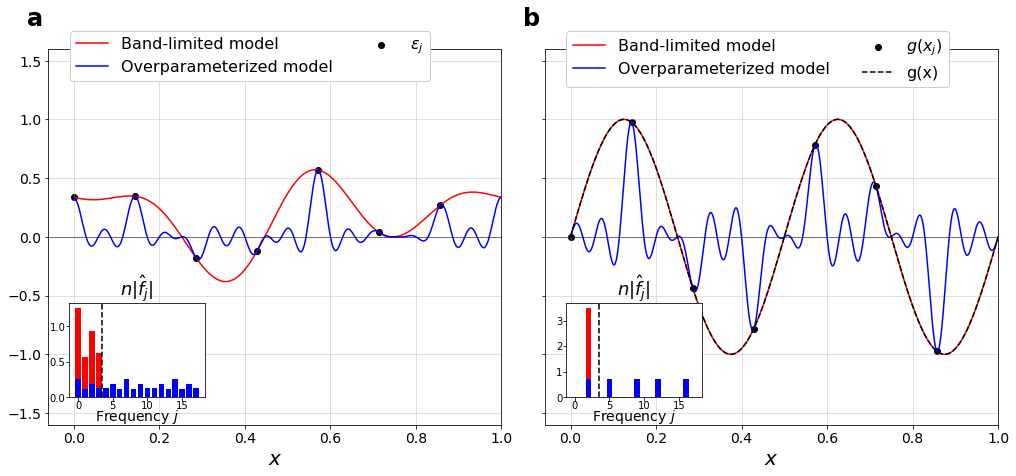

In [4]:
# Simulate noisy signal experiment
n = 7
sigma = 0.4
k_pure = 2


# Define a signal that acts on discrete time samples (even "continuous" time)
def signal(times):
    return np.sin(2 * np.pi * k_pure * times)


time_samples = np.linspace(0, 1-1/n, n) # this gives dx = 1/n. i.e. x = (0, 1/n, ..., (n-1)/n)
time_continuous = np.linspace(0, 1, 1000)
noise_sampled = np.random.normal(0, scale=sigma, size=len(time_samples))
noiseless_sampled = signal(time_samples)
noiseless_cont = signal(time_continuous)


fig, axes = plt.subplots(1, 2, figsize=(14, 6.5), sharey=True, constrained_layout=True)

# An explanation for this code block:
# Recall bbox_to_anchor is (xlim[0], ylim[0], xlim[1], ylim[1]) where xlim,ylim describe the 
# bounding box for the axis; transAxes is used to specify this in terms of relative size of 
# parent axis. However to use the bbox_to_anchor specifications we need to set height and 
# width as 100% and then the inset geometry is initialized taking those parameters
# with respect to the bbox_to_anchor.
inset_kwargs = {'width': "100%", 'height': "100%", 'loc': "lower left", 'bbox_to_anchor': (0.035, 0.06, .3, .25)}
ax0_inset = inset_axes(axes[0], **dict(inset_kwargs, **{'bbox_transform': axes[0].transAxes}))
ax1_inset = inset_axes(axes[1], **dict(inset_kwargs, **{'bbox_transform': axes[1].transAxes}))

# Seed the random noise for reproducibility
# Note that the inset layout is highly dependent on this seed
# if you change the seed, the signal might get hidden behind inset
np.random.seed(127)

# each experiment contains number of cohorts, label name, and other metadata
for j, experiment in enumerate([
    (0, 'Band-limited model', 'red'), 
    (4, 'Overparameterized model', 'blue')]):

    m_cohorts, label, color = experiment
    
    # rebuild a function that interpolates with minimum norm for each case
    weights = np.ones(n * (m_cohorts + 1))
    f_opt_eps = signals.compute_optimal_model(time_continuous, noise_sampled, weights)
    f_opt_signal = signals.compute_optimal_model(time_continuous, noiseless_sampled, weights)
    
    axes[0].plot(time_continuous, f_opt_eps.real, c=color, label=label)
    axes[1].plot(time_continuous, f_opt_signal.real, c=color, label=label)
    
    
    # Computing Fourier coefficients for optimal model
    freqs, fourier_eps = signals.compute_optimal_model_fourier_coeffs(noise_sampled, weights)
    freqs, fourier_signal = signals.compute_optimal_model_fourier_coeffs(noiseless_sampled, weights)
    idx_keep = np.where(freqs>=0)
    ax0_inset.bar(freqs[idx_keep], n*abs(fourier_eps[idx_keep]), color=color)
    ax1_inset.bar(freqs[idx_keep], n*abs(fourier_signal[idx_keep]), color=color)
    

# Plot 'true' signals
axes[0].scatter(time_samples, noise_sampled, c='k', label=r"$\epsilon_j$")
axes[1].scatter(time_samples, noiseless_sampled, c='k', label=r"$g(x_j)$")
axes[1].plot(time_continuous, signal(time_continuous), c='k', ls='--', label='g(x)')

# Main axis details
for ax in axes:
    ax.set_xlabel(r"$x$", size=20)
    ax.axhline(0, c='k', alpha=1, lw=.5)
    ax.grid(alpha=0.5)
    ax.set_ylim(-1.6, 1.6)
    ax.set_xlim(-0.06, 1.)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
axes[0].legend(prop={'size': 16}, framealpha=1, ncol=2, loc='upper left', bbox_to_anchor=(0.03, 1.07))
axes[1].legend(prop={'size': 16}, framealpha=1, ncol=2, loc='upper left', bbox_to_anchor=(0.03, 1.07))

axes[0].text(-0.03, 1.08, r"a", horizontalalignment='center', 
             verticalalignment='center', size=24, transform=axes[0].transAxes, weight="bold")
axes[1].text(-0.03, 1.08, r"b", horizontalalignment='center', 
             verticalalignment='center', size=24, transform=axes[1].transAxes, weight="bold")

# Inset details
for ax in [ax0_inset, ax1_inset]:
    # dashed line denoting bandlimit; '0.5' shift due to bars being centered at frequencies
    ax.axvline((n-1)/2 + 0.5, c='k', ls='--')
    ax.axhline(0, c='k', lw=0.5)
    ax.set_title(r"$n|\hat{f}_j|$", size=18)
    ax.set_xlabel(r"Frequency $j$", labelpad=-3, size=14)
    ax.tick_params(axis="y",direction="out", pad=0)
    ax.tick_params(axis="x",direction="out", pad=0)
    
fig.savefig("../figures/figure2.pdf",bbox_inches='tight')